# Hard Drive Failure

### Objective:

Explore hard drive failure data and provide device failure analysis using the Kaplan-Meier model.  

### Data:

This is data provided by BackBlaze.  They are an online file backup and storage company. They have posted their log files of hard drives.  There are 256 S.M.A.R.T statistics recorded for each drive along with model numbers, makes and datestamps.

### Data Prep:

Because this data is large, 3.5gb for 2 years.  I have ran the first part on my system and uploaded a smaller simpler table of the values that are important for the model.  The below script has taken the 3.5gb and made it a 5.2mb file that can be followed using ipython.  The script will take the S.M.A.R.T. value number 9 which is a count of the numbers it is powered on.

First Import Dependencies:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import lifelines as sa
import glob, os
from collections import OrderedDict
import patsy as pt

## __Do not run, as the files are too large.  In place to show work.__

In [ ]:
#DO NOT RUN, files are too large
os.chdir("C:\\Users\\Andrew\\Downloads\\hdd\\")

allFiles = glob.glob("*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, usecols=[0, 1, 2, 3,4, 20])
    list_.append(df)
df = pd.concat(list_)
df.reset_index(inplace=True)

os.chdir("C:\\Users\\Andrew\\Documents")

df["mindate"] = df["date"].groupby(df["serial_number"]).transform('min')
df["maxdate"] = df["date"].groupby(df["serial_number"]).transform('max')
df["minhours"] = df["smart_9_raw"].groupby(df["serial_number"]).transform('min')
df["maxhours"] = df["smart_9_raw"].groupby(df["serial_number"]).transform('max')
df["nrec"] = df["date"].groupby(df["serial_number"]).transform('count')

df = df[["date", "serial_number","model","capacity_bytes","mindate","maxdate",
        "minhours", "maxhours","nrec","failure"]]

df = df.sort_values("failure",ascending=False)
df = df.drop_duplicates(["serial_number"],keep="first")
df.reset_index(inplace=True)

#Save off file
df.to_csv("HDD-log.csv", index=False)

### Clean the Data:

The first process is to bring the data in and get a look and feel for it.  

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AKaszpurenko/ExampleWork/master/HDD-log.csv")
df.head()


,index,date,serial_number,model,capacity_bytes,mindate,maxdate,minhours,maxhours,nrec,failure
0,14109811,2014-10-02,S1F04ZNE,ST3000DM001,3.000593e+12,2013-04-10,2014-10-07,7993.0,21072.0,490,1.0
1,3289347,2013-10-24,S1F0BF5S,ST3000DM001,3.000593e+12,2013-04-10,2013-10-24,6545.0,11231.0,142,1.0
2,9065502,2014-05-12,Z3016NNT,ST4000DM000,4.000787e+12,2014-02-26,2014-05-12,12.0,1783.0,76,1.0
3,12257298,2014-08-13,S1F030WE,ST3000DM001,3.000593e+12,2013-04-10,2014-09-11,9524.0,21977.0,461,1.0
4,12709878,2014-08-25,W1F028MX,ST3000DM001,3.000593e+12,2013-04-10,2014-08-25,5194.0,17236.0,446,1.0


Each row reperesents one unique hard drive and the information we have about it and what it's past history was.

The columns are as follows:
* index = a unique row number
* date = date
* serial_number = Serial number of the hard drive
* model = Model of hard drive
* cabacity_bytes = this is capacity in bytes
* minmdate = the earliest date we have records of this hard drive
* maxdate = the latest date we have records of this hard drive
* minhours = the shortest amount of hours we have on record for this drive (S.M.A.R.T. valeu #9)
* maxhours = the max amount of hours we have on record for this drive (S.M.A.R.T. valeu #9)
* nrec = number of records
* failure = 1 => Failed, 0 => Still working

Note that the raw data that was used to compute these logs was from 1-1-13 to 12-31-14 (2 years), so some drives started up before this and lasted well past the 2 year cut off we have of this data.

In [3]:
#check for anything odd with failed
df["failure"].value_counts()

0.0    46177
1.0     2930
Name: failure, dtype: int64

In [4]:
#check for any hard drive that is just too small
df["capacity_bytes"].value_counts()



4.000787e+12    26250
3.000593e+12    12394
2.000399e+12     5259
1.500302e+12     3106
1.000205e+12      728
5.001079e+11      392
6.001175e+12      317
1.600419e+11      252
3.200729e+11      146
8.002636e+10      131
2.500594e+11      127
6.003326e+17        2
1.194001e+12        1
2.500000e+11        1
1.073493e+17        1
Name: capacity_bytes, dtype: int64

We can see there are a few hard drives that are extremely large in size, 600TB and 250TB respectively, but again the sample size is too small to be meaningful.  So we will drop those that are too small and those that are too big.  Also we will make the Capacity number easier to read.

In [5]:
#adjust to TB size and also round
df["capacity"] = df["capacity_bytes"].apply(lambda x: (round(x/1000000000000,2)))

#drop hdd that are too small of records or too large
df = df.loc[(df['capacity']<6.5) & (df['capacity']>1.5)]
df.groupby(["capacity"]).size()

capacity
2.0     5259
3.0    12394
4.0    26250
6.0      317
dtype: int64

In [6]:
#Create the make/model of the drives
df["make"] = df["model"].apply(lambda x:x.split()[0])
df["model"] = df["model"].apply(lambda x: x.split()[1] if len(x.split())>1
else x)
df.groupby(["make","model"]).size()



make          model          
HGST          HDS5C4040ALE630        6
              HDS724040ALE640       42
              HMS5C4040ALE640     7166
              HMS5C4040BLE640     3115
Hitachi       HDS5C3030ALA630     4651
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2719
              HDS722020ALA330     4774
              HDS723020BLA642       11
              HDS723030ALA640     1046
              HDS723030BLE640       10
              HDS724040ALE640        1
ST2000DL001   ST2000DL001           12
ST2000DL003   ST2000DL003           16
ST2000DM001   ST2000DM001            8
ST2000VN000   ST2000VN000            5
ST3000DM001   ST3000DM001         4703
ST32000542AS  ST32000542AS         385
ST320005XXXX  ST320005XXXX          17
ST33000651AS  ST33000651AS         351
ST4000DM000   ST4000DM000        12976
ST4000DX000   ST4000DX000          180
ST6000DX000   ST6000DX000           45
TOSHIBA       DT01ACA300            60
WDC           WD20EFRX            

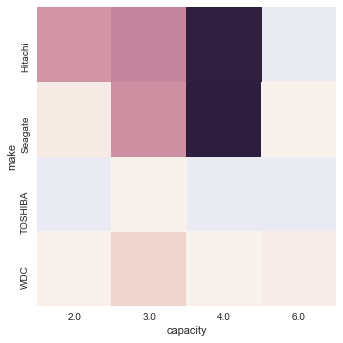

In [7]:
#Create the Seagate make and Hitachi
df["make"] = df["make"].apply(lambda x:"Seagate" if x[:2]== "ST" else x)
df.loc[df["make"] == "HGST","make"] = "Hitachi"

#Visual inspection of the data
gp = df.groupby(["make","capacity"]).size().unstack()
sb.heatmap(gp, mask=pd.isnull(gp), robust=True, square=True,cbar=False)

Toshiba has very little presence.  We will take this out of the data as the sample size is too small.  We are now able visualize how much the 4TB and under is making up this data.  

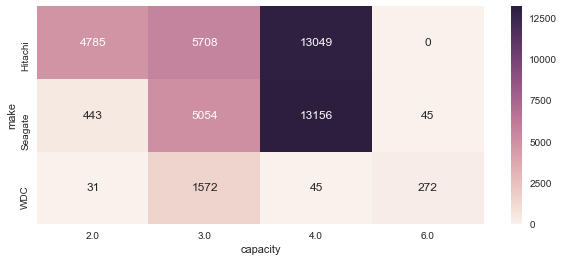

In [8]:
#Shrink to just Hitachi, Seagate, WD
df = df.loc[df["make"].isin(["Hitachi", "Seagate", "WDC"])]

#visual inspection of date start and ending
df["mindate"] = pd.to_datetime(df["mindate"])
df["maxdate"] = pd.to_datetime(df["maxdate"])
df['mindateym'] = df['mindate'].apply(lambda x: x.strftime('%Y%m'))
df['maxdateym'] = df['maxdate'].apply(lambda x: x.strftime('%Y%m'))

#Grouping by Make and Capacity
gp = df.groupby(["make","capacity"]).size().unstack()
gp[pd.isnull(gp)]=0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,4)
                         , squeeze=False, sharex=True, sharey=True)
sb.heatmap(gp, annot=True, fmt='.0f', ax=axes[0,0])



In [9]:
gp = df.groupby(["make","capacity","failure"]).size().unstack()
gp["proportion"] = gp[1]/ gp.sum(axis=1)
gp.rename(columns={0:"active", 1:"failure"}, inplace=True)
gp.reset_index(inplace=True)
gp.head(20)

failure,make,capacity,active,failure,proportion
0,Hitachi,2.0,4705.0,80.0,0.016719
1,Hitachi,3.0,5626.0,82.0,0.014366
2,Hitachi,4.0,12959.0,90.0,0.006897
3,Seagate,2.0,391.0,52.0,0.117381
4,Seagate,3.0,3426.0,1628.0,0.322121
5,Seagate,4.0,12869.0,287.0,0.021815
6,Seagate,6.0,45.0,NaN,NaN
7,WDC,2.0,29.0,2.0,0.064516
8,WDC,3.0,1500.0,72.0,0.045802
9,WDC,4.0,45.0,NaN,NaN


This is now a clean data set with Clean data set, now to use two different models on the dataset.  With even this basic look we can see that the Seagates are failing at a higher rate than the other makers.  What we can't say until we run the Kaplan-Meier Model is:  
* Are the Seagate drives failing faster due to them being in service longer?
* Do the Seagates appear to start failing after a certain point in time or is it a gradual failure?

# Kaplan-Meier Model

The Kaplan-Meier model gives a maxium-likelihood estimate of survival function.
\begin{equation}
\hat S(t) = \prod\limits_{t_i \\< t} \frac{n_i - d_i}{n_i}
\end{equation}

* d = death/failure
* n = number of participants
* t = time
* i = specific interval

This is a cummulative product and gives a non-increasing curve where at anytime step, we can estimate the probability of survival from the start.

First step is to define the Kaplan function and charting function:

In [10]:
#Kaplan Meier Model
def  estimate_cond_mean(S):
    """Quick est of conditional mean lifetime"""
    fstar = -S.diff() / (1-S.iloc[-1.0])
    Sstar = (S-S.iloc[-1,0]) / (1-S.iloc[-1,0])
    llstarr = fstar/ Sstar

    llstar[pd.isnull(llstar)] = 0
    llstar = llstar[np.isfinite(llstar)]
    llstarcs = llstar.cumsum().reset_index()
    llstarcs["timelinediff"] = np.append(llstarcs["timeline"].diff().value[1:],0)
    llstarcs["auc"] = llstarcs["timelinediff"]*llstarcs["KM_estimate"]
    return np.nansum(llstarcs["auc"]).round()

#Generic plotting
def plot_km(km, axes, suptxt='', subtxt='', i=0, j=0, arws=[], xmax=0, smlfs=10):

    ax = km.plot(ax=axes[i,j], title=subtxt, legend=False)
    plt.suptitle(suptxt, fontsize=14)
    axes[i,j].axhline(0.5, ls='--', lw=0.5)
    axes[i,j].annotate('half-life', fontsize=smlfs, color='b'
            ,xy=(0,0.5), xycoords='axes fraction'
            ,xytext=(10,4), textcoords='offset points')

    S = km.survival_function_
    hl = S.loc[S['KM_estimate']<0.5,'KM_estimate'].head(1)
    if len(hl) == 1:
        axes[i,j].annotate('{:.0f}'.format(hl.index[0]), fontsize=smlfs
            ,xy=(0,0.5), xycoords='axes fraction'
            ,xytext=(10,-12), textcoords='offset points', color='b')

    for pt in arws:
        tml = km.survival_function_[:pt].tail(1)
        plt.annotate('{:.1%}\n@ {:.0f}hrs'.format(tml['KM_estimate'].values[0],tml.index.values[0])
                ,xy=(tml.index.values,tml['KM_estimate'].values), xycoords='data'
                ,xytext=(6,-50), textcoords='offset points', color='#007777', fontsize=smlfs
                ,arrowprops={'facecolor':'#007777', 'width':2})

    ax.set_ylim([0,1])
    ax.set_xlim([0,xmax])




###  All hard drives Failure chart

First step is to see how all the hard drives in aggregate.

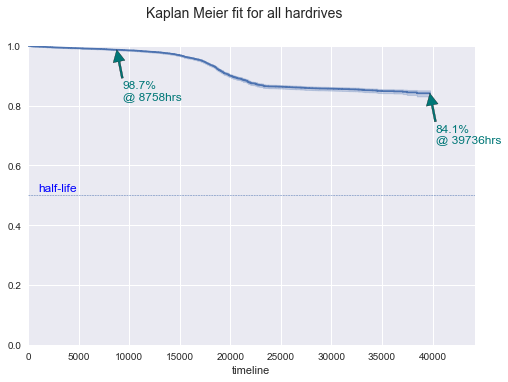

In [11]:
#All hard drives Failure rate
fig, axes = plt.subplots(nrows=1, ncols=1
                         ,squeeze=False, sharex=True, sharey=True)
km = sa.KaplanMeierFitter()
km.fit(durations=df['maxhours'], event_observed=df['failure'])
plot_km(km, axes, xmax=df.shape[0], arws=[8760, 43830]
        ,suptxt='Kaplan Meier fit for all hardrives', smlfs=12)

We can see that at 1 year (8758 hours), 98.7% of the drives are working.  But at 4.5 years, only 84.1% are still working. Clearly the rapid drop approaching year 2 is indication that something else might be at works.  Next step is to dive in and look at the drives and manufactors and how they influence the survival rate.

### Failure by Make

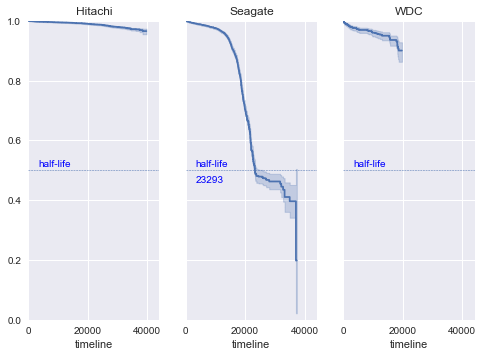

In [12]:
#Lifetime by Make
fig,axes = plt.subplots(nrows=1, ncols=len(df["make"].value_counts()),
                         squeeze=False, sharex=True, sharey=True)
for j, mfr in enumerate(np.unique(df["make"])):
    dfsub = df.loc[df["make"]==mfr]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub["maxhours"], event_observed=dfsub["failure"])
    plot_km(km, axes, j=j, subtxt=mfr, xmax=df.shape[0])




This confirms the observation earlier with the table of manufactors that Seagate drives are failing above the norm.  We don't know if this is one particular model or all Seagates have this problem.  But this clearly indicates that Seagate drives are having a problem.

### Failure by Make and Capacity

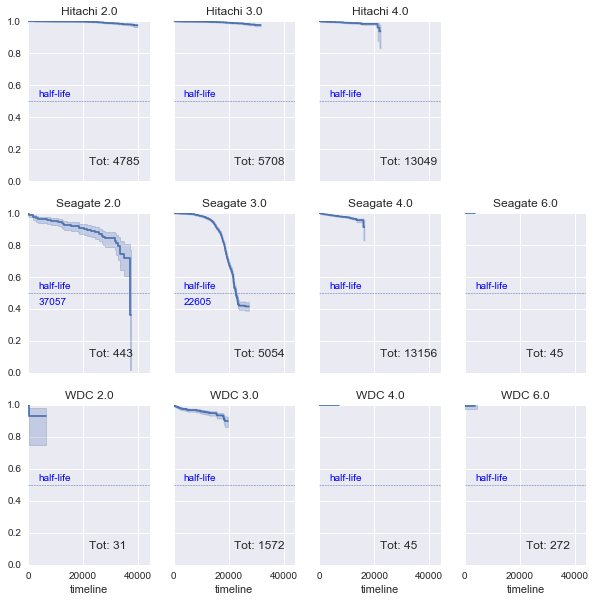

In [13]:
fig, axes = plt.subplots(nrows=len(df['make'].value_counts())
                         ,ncols=len(df['capacity'].value_counts())
                         ,squeeze=False, sharex=True, sharey=True, figsize=(10,10))

for i, mfr in enumerate(np.unique(df['make'])):
    for j, cap in enumerate(np.unique(df['capacity'])):
        dfsub = df.loc[(df['make']==mfr) & (df['capacity']==cap)]
        if dfsub.shape[0]!=0:
            km = sa.KaplanMeierFitter()
            km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failure'])
            plot_km(km, axes, i=i, j=j, subtxt='{} {}'.format(mfr, cap), xmax=df.shape[0])
            axes[i,j].annotate('Tot: {}'.format(dfsub.shape[0]), xy=(0.5,0.1), xycoords='axes fraction')
        else:
            axes[i,j].axis('off')

This is probably the most illuminating chart.  We can see clearly that something is wrong with the 2 & 3 Seagate TB hard drives.  After about 2.5 years, half of the Seagate 3.0 TB have failed. WD & Hitatchi seem to both have few failures.  We can also see that the WD 2TB,4TB,6TB drives we don't have a long burn out of time with to help us see if this problem might also be affecting them.  

### Examination of 3TB capacity by make

Taking the 3TB hard drives and over laying the survival functions we can see how pronounced this problem is.

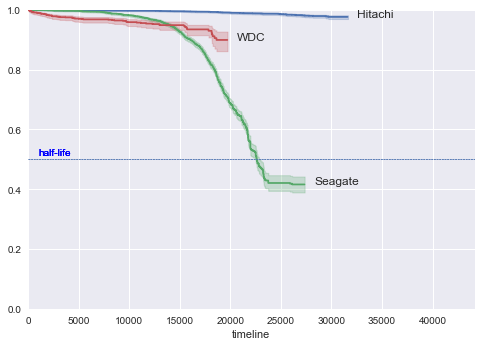

In [14]:
#Just looking at 3TB harddrives by make
dd = OrderedDict()
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, sharex=True, sharey=True)

for j, mfr in enumerate(np.unique(df["make"])):
    dd[mfr]= {8760:"",17520:"",26280:""}
    dfsub = df.loc[(df["make"]==mfr) & (df["capacity"]==3.0)]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub["maxhours"], event_observed=dfsub["failure"])
    ax = km.plot(ax=axes[0,0], legend=False)
    axes[0,0].axhline(0.5, ls='--', lw=0.5)
    axes[0,0].annotate('half-life', xy=(0,0.5), xycoords='axes fraction'
                ,xytext=(10,4), textcoords='offset points', color='b', fontsize=10)
    ax.set_ylim([0,1])
    ax.set_xlim([0,df.shape[0]])
    fnlS = km.survival_function_.iloc[-1:, :]
    axes[0,0].annotate('{}'.format(mfr), xy=(fnlS.index.values[0],fnlS.values[0][0])
                       ,xycoords='data', fontsize=12
                       ,xytext=(10,0), textcoords='offset points')


### Kaplin-Meier Observations:

As we can see with this simple model we can see after how many hours we expect drives to fail.  This also illustrated that we can not just look at manufactor or size but need to examine both as a whole.  

* In the first year (8760 hours), WDC hard drives fail more (in the 3TB and overall charts).  
* After 22k hours (2.6yrs), 50% of Seagate 3 TB hard drives we would expect to fail. 
* Compare this with 98% of Hitachi 3TB drives still working after 2.6yrs.
* Western Digitial drives fail quick then start failing at a slow gradual rate and start ramping up the failure (in the 3TB and overall charts).